In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE





In [66]:
from sklearn.metrics import confusion_matrix

def confusion(y_val, y_pred):
    # Assuming y_val and y_pred are defined
    cm = confusion_matrix(y_val, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def prediction_finale(modelS, modelP, X_trainS, y_trainS, X_trainP, y_trainP, X_testS, id_testS, X_testP, id_testP, oversamplingS = True, oversamplingP = False, threshold=0.5):
    if oversamplingS:
        smote = SMOTE()
        X_trainS, y_trainS = smote.fit_resample(X_trainS, y_trainS)
    if oversamplingP:
        smote = SMOTE()
        X_trainP, y_trainP = smote.fit_resample(X_trainP, y_trainP)
    X_testS = X_testS.fillna(X_testS.median())
    X_testP = X_testP.fillna(X_testP.median())
    modelS.fit(X_trainS, y_trainS)
    modelP.fit(X_trainP, y_trainP)
    y_predS = modelS.predict(X_testS)
    y_predP = modelP.predict(X_testP)
    y_predS = (y_predS > threshold).astype(int)
    y_predP = (y_predP > threshold).astype(int)
    subS = pd.DataFrame({'id': id_testS, 'Depression': y_predS})
    subP = pd.DataFrame({'id': id_testP, 'Depression': y_predP})

    sub = pd.concat([subS, subP], axis=0)
    sub = sub.sort_values(by='id')
    sub.to_csv('submission.csv', index=False)
    

def test_model(modelS, modelP, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS = True, oversamplingP = False):
    if oversamplingS:
        smote = SMOTE()
        X_trainS, y_trainS = smote.fit_resample(X_trainS, y_trainS)
    if oversamplingP:
        smote = SMOTE()
        X_trainP, y_trainP = smote.fit_resample(X_trainP, y_trainP)
    X_trainS, X_valS, y_trainS, y_valS = train_test_split(X_trainS, y_trainS, test_size=0.2, random_state=42)
    X_trainP, X_valP, y_trainP, y_valP = train_test_split(X_trainP, y_trainP, test_size=0.2, random_state=42)
    modelS.fit(X_trainS, y_trainS)
    modelP.fit(X_trainP, y_trainP)
    y_predS = modelS.predict(X_valS)
    y_predP = modelP.predict(X_valP)
    print('Model S')
    print('Accuracy:', accuracy_score(y_valS, y_predS))
    print('Balanced accuracy:', balanced_accuracy_score(y_valS, y_predS))
    print('AUC:', roc_auc_score(y_valS, y_predS))
    print('Model P')
    print('Accuracy:', accuracy_score(y_valP, y_predP))
    print('Balanced accuracy:', balanced_accuracy_score(y_valP, y_predP))
    print('AUC:', roc_auc_score(y_valP, y_predP))
    confusion(y_valS, y_predS)
    confusion(y_valP, y_predP)
    

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [49]:
def preprocess_all_data(train, test, split=False):


    X_train = train.drop('Depression', axis=1)
    y_train = train['Depression']
    X = pd.concat([X_train, test], axis=0)
    len_train = len(X_train)
    len_test = len(test)
    len_X = len(X)
    print('len_train:', len_train)
    print('len_test:', len_test)
    print('len_X:', len_X)


    if split:




        X = X.drop(['Name'], axis=1)
        X['Pressure'] = X[['Work Pressure', 'Academic Pressure']].max(axis=1)
        X = X.drop(['Work Pressure', 'Academic Pressure'], axis=1)
        X['Gender'] = (X['Gender'] == 'Male').astype(int)
        X.loc[X['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
        X['Satisfaction'] = X[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
        X = X.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)
        X['Family History of Mental Illness'] = (X['Family History of Mental Illness'] == 'Yes').astype(int)
        X['Have you ever had suicidal thoughts ?'] = (X['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)


        X = X.drop(['City'], axis=1)


        # v = X["City"].value_counts() 
        # tmp = X[X['City'].isin(v.index[v.gt(10)])]
        # tmp = pd.get_dummies(tmp, columns=['City'])
        # tmp_cols = [col for col in tmp.columns if col.startswith('City_')]
        # X = pd.get_dummies(X, columns=['City'])
        # City_cols = [col for col in X.columns if col.startswith('City_')]
        # X[City_cols] = X[City_cols].astype(int)
        # X = X.drop(tmp_cols, axis=1)



        diet_mapping = {'Moderate': 1.0, 'Unhealthy': 0.0, 'Healthy': 2.0}
        X['Dietary Habits'] = X['Dietary Habits'].map(diet_mapping)
        v = X["Profession"].value_counts() 

        X = pd.get_dummies(X, columns=['Profession'])
        profession_cols = [col for col in X.columns if col.startswith('Profession_')]
        X[profession_cols] = X[profession_cols].astype(int)
        X = X.drop(['Working Professional or Student'], axis=1)
        v = X["Degree"].value_counts() 
        X = pd.get_dummies(X, columns=['Degree'])
        degree_cols = [col for col in X.columns if col.startswith('Degree_')]
        X[degree_cols] = X[degree_cols].astype(int)
        dict_sleep = {'Less than 5 hours': 4.0, '5-6 hours': 5.5, '6-7 hours': 6.5, '7-8 hours': 7.5, 'More than 8 hours': 9.0, '2-3 hours': 2.5, '3-4 hours': 3.5, '4-5 hours': 4.5, '4-6 hours': 5.0}
        X['Sleep Duration'] = X['Sleep Duration'].map(dict_sleep)
        X['CGPA'] = X['CGPA'].fillna(X['CGPA'].mean())

        X_train = X[:len_train]
        X_test = X[len_train:]

        X_trainS = X_train[X_train['Profession_Student'] == 1]
        X_trainP = X_train[X_train['Profession_Student'] == 0]
        X_trainP = X_trainP.drop(['Profession_Student'], axis=1)
        X_trainP = X_trainP.drop(['CGPA'], axis=1)
        X_trainS = X_trainS.drop(profession_cols, axis=1)

        X_testS = X_test[X_test['Profession_Student'] == 1]
        X_testP = X_test[X_test['Profession_Student'] == 0]
        X_testP = X_testP.drop(['Profession_Student'], axis=1)
        X_testP = X_testP.drop(['CGPA'], axis=1)
        X_testS = X_testS.drop(profession_cols, axis=1)
        

        y_trainS = y_train[X_trainS.index]
        y_trainP = y_train[X_trainP.index]

        id_testS = X_testS['id']
        id_testP = X_testP['id']
        X_trainS = X_trainS.drop(['id'], axis=1)
        X_trainP = X_trainP.drop(['id'], axis=1)
        X_testS = X_testS.drop(['id'], axis=1)
        X_testP = X_testP.drop(['id'], axis=1)

        


        return X_trainS, y_trainS, X_trainP, y_trainP, X_testS, id_testS, X_testP, id_testP



    else :
        X = X.drop(['id', 'Name'], axis=1)
        X['Pressure'] = X[['Work Pressure', 'Academic Pressure']].max(axis=1)
        X = X.drop(['Work Pressure', 'Academic Pressure'], axis=1)
        X['Gender'] = (X['Gender'] == 'Male').astype(int)
        X.loc[X['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
        X['Satisfaction'] = X[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
        X = X.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)
        X['Family History of Mental Illness'] = (X['Family History of Mental Illness'] == 'Yes').astype(int)
        X['Have you ever had suicidal thoughts ?'] = (X['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)


        X = X.drop(['City'], axis=1)


        # v = X["City"].value_counts() 
        # tmp = X[X['City'].isin(v.index[v.gt(10)])]
        # tmp = pd.get_dummies(tmp, columns=['City'])
        # tmp_cols = [col for col in tmp.columns if col.startswith('City_')]
        # X = pd.get_dummies(X, columns=['City'])
        # City_cols = [col for col in X.columns if col.startswith('City_')]
        # X[City_cols] = X[City_cols].astype(int)
        # X = X.drop(tmp_cols, axis=1)



        diet_mapping = {'Moderate': 1.0, 'Unhealthy': 0.0, 'Healthy': 2.0}
        X['Dietary Habits'] = X['Dietary Habits'].map(diet_mapping)
        v = X["Profession"].value_counts() 

        X = pd.get_dummies(X, columns=['Profession'])
        profession_cols = [col for col in X.columns if col.startswith('Profession_')]
        X[profession_cols] = X[profession_cols].astype(int)
        X = X.drop(['Working Professional or Student'], axis=1)
        v = X["Degree"].value_counts() 
        X = pd.get_dummies(X, columns=['Degree'])
        degree_cols = [col for col in X.columns if col.startswith('Degree_')]
        X[degree_cols] = X[degree_cols].astype(int)
        dict_sleep = {'Less than 5 hours': 4.0, '5-6 hours': 5.5, '6-7 hours': 6.5, '7-8 hours': 7.5, 'More than 8 hours': 9.0, '2-3 hours': 2.5, '3-4 hours': 3.5, '4-5 hours': 4.5, '4-6 hours': 5.0}
        X['Sleep Duration'] = X['Sleep Duration'].map(dict_sleep)
        X['CGPA'] = X['CGPA'].fillna(X['CGPA'].mean())

        X_train = X[:len_train]
        X_test = X[len_train:]


        return X_train, X_test, y_train
    



In [50]:
X_trainS, y_trainS, X_trainP, y_trainP, X_testS, id_testS, X_testP, id_testP = preprocess_all_data(train, test, split=True)

train_S = pd.concat([X_trainS, y_trainS], axis=1)
train_S = train_S.dropna()
X_trainS = train_S.drop('Depression', axis=1)
y_trainS = train_S['Depression']

train_P = pd.concat([X_trainP, y_trainP], axis=1)
train_P = train_P.dropna()
X_trainP = train_P.drop('Depression', axis=1)
y_trainP = train_P['Depression']

# X_trainS2, X_valS, y_trainS2, y_valS = train_test_split(X_trainS, y_trainS, test_size=0.2, random_state=42)
# X_trainP2, X_valP, y_trainP2, y_valP = train_test_split(X_trainP, y_trainP, test_size=0.2, random_state=42)

len_train: 140700
len_test: 93800
len_X: 234500


Model S
Accuracy: 0.8732955415964455
Balanced accuracy: 0.873304269707146
AUC: 0.8733042697071459
Model P
Accuracy: 0.9640597072605188
Balanced accuracy: 0.9640530409353512
AUC: 0.9640530409353512


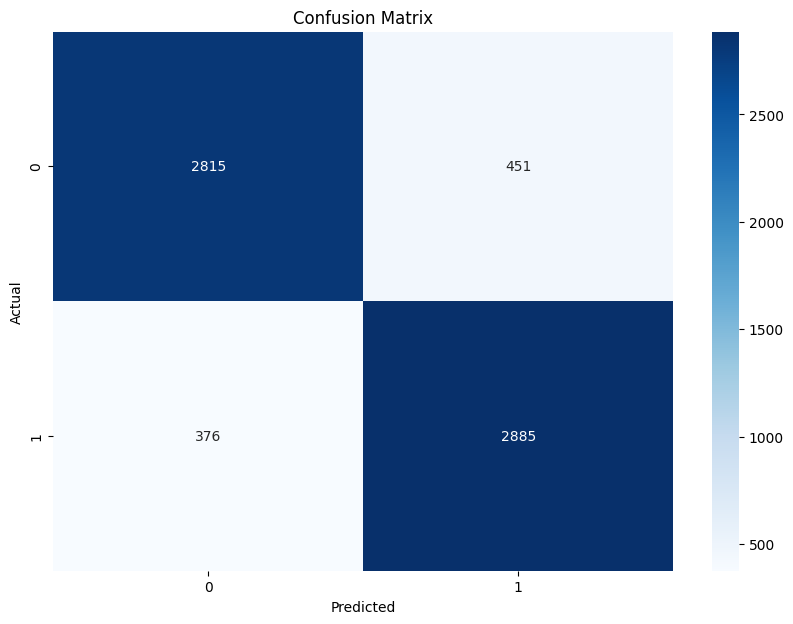

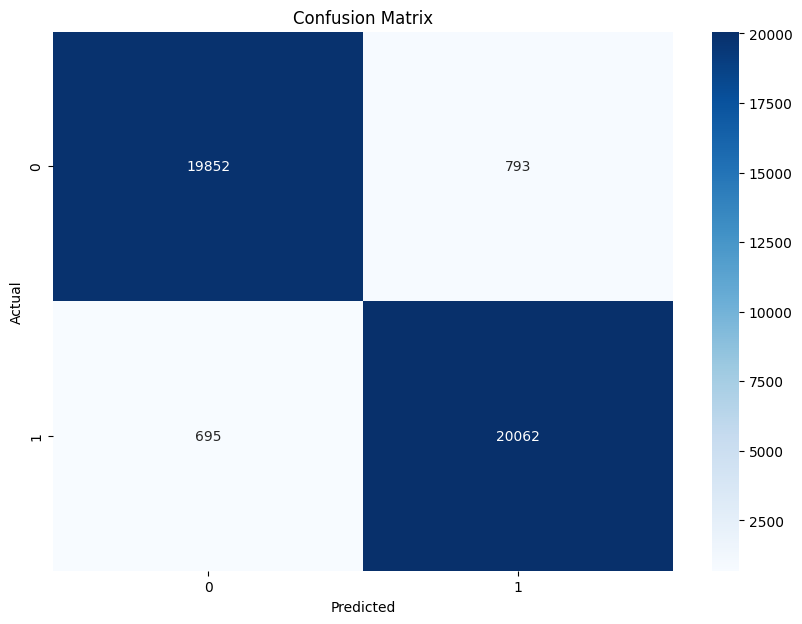

In [64]:
gb1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

test_model(gb1, gb2, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=True, oversamplingP=True)

Model S
Accuracy: 0.846457399103139
Balanced accuracy: 0.8384102401864043
AUC: 0.8384102401864042
Model P
Accuracy: 0.9593719506786126
Balanced accuracy: 0.8234935181734284
AUC: 0.8234935181734284


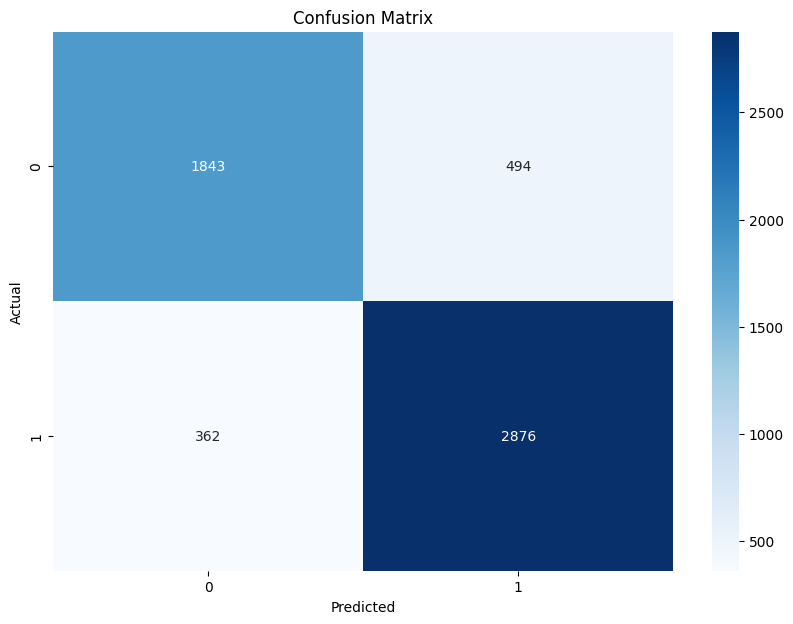

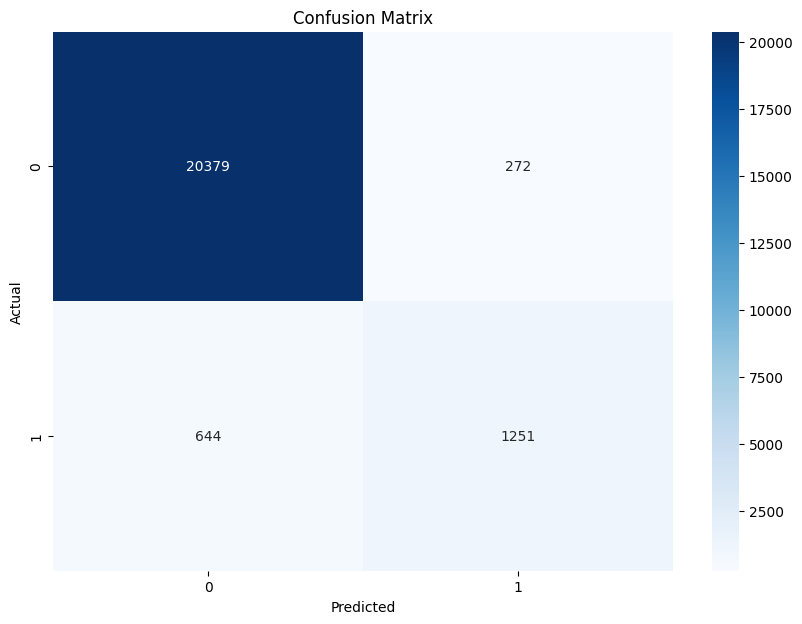

In [65]:
gb1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

test_model(gb1, gb2, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=False, oversamplingP=False)

In [68]:
gb1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lr = LogisticRegression(random_state=42)
prediction_finale(gb1, gb2, X_trainS, y_trainS, X_trainP, y_trainP, X_testS, id_testS, X_testP, id_testP, oversamplingS=False, oversamplingP=False, threshold=0.5)

In [55]:
# over sampling
sm = SMOTE(random_state=42)
X_trainS_res, y_trainS_res = sm.fit_resample(X_trainS2, y_trainS2)



In [56]:
# XGboost {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}
from xgboost import XGBClassifier
xgb_S = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=200, objective='binary:logistic')
xgb_S.fit(X_trainS_res, y_trainS_res)
y_predS = xgb_S.predict(X_valS)
print('Accuracy for students:', accuracy_score(y_valS, y_predS))

xgb_P = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=200, objective='binary:logistic')
xgb_P.fit(X_trainP2, y_trainP2)
y_predP = xgb_P.predict(X_valP)
print('Accuracy for professionals:', accuracy_score(y_valP, y_predP))

Accuracy for students: 0.8425112107623318
Accuracy for professionals: 0.9603920872882108


In [54]:
y_subS = xgb_S.predict(X_testS)
y_subP = xgb_P.predict(X_testP)

subS = pd.DataFrame({'id': id_testS, 'Depression': y_subS})
subP = pd.DataFrame({'id': id_testP, 'Depression': y_subP})

sub = pd.concat([subS, subP], axis=0)
sub = sub.sort_values(by='id')
sub.to_csv('submission.csv', index=False)

In [42]:
logreg = LogisticRegression(C=1, max_iter=100, penalty ='l1', solver = 'liblinear')
logreg.fit(X_trainS, y_trainS)
y_predS = logreg.predict(X_valS)
print('Accuracy for students:', accuracy_score(y_valS, y_predS))

logreg.fit(X_trainP, y_trainP)
y_predP = logreg.predict(X_valP)
print('Accuracy for professionals:', accuracy_score(y_valP, y_predP))

Accuracy for students: 0.846457399103139
Accuracy for professionals: 0.9607469174132884


In [31]:
estimators = [('gb', gb), ('logreg', logreg)]
vote = VotingClassifier(estimators=estimators, voting='soft')
vote.fit(X_trainS2, y_trainS2)
y_predS = vote.predict(X_valS)
print('Accuracy:', accuracy_score(y_valS, y_predS))

Accuracy: 0.8471748878923767


0:	learn: 0.6281241	total: 52.8ms	remaining: 10.5s
100:	learn: 0.3362596	total: 326ms	remaining: 320ms
199:	learn: 0.3219996	total: 575ms	remaining: 0us
Accuracy: 0.8469955156950673


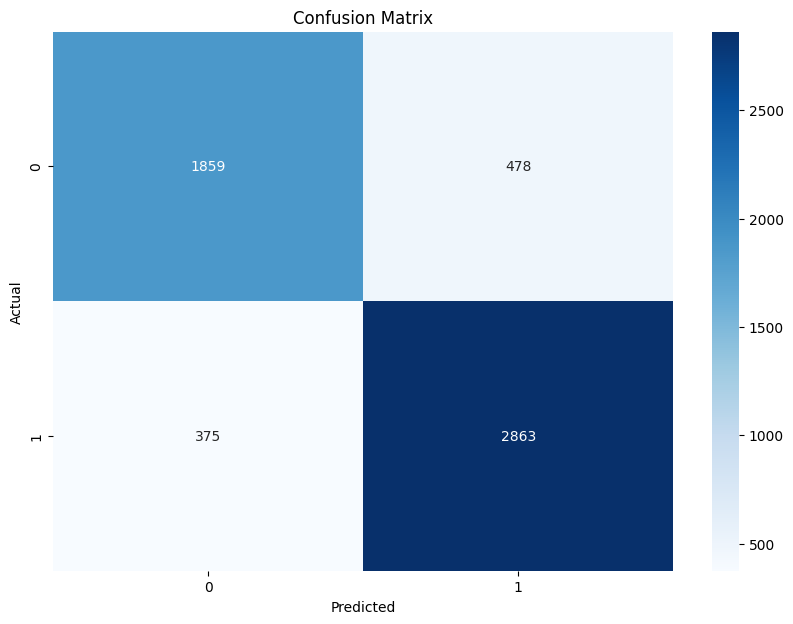

0:	learn: 0.5185673	total: 5.38ms	remaining: 1.07s
100:	learn: 0.0983075	total: 751ms	remaining: 736ms
199:	learn: 0.0944402	total: 1.47s	remaining: 0us
Accuracy: 0.9604364410538455


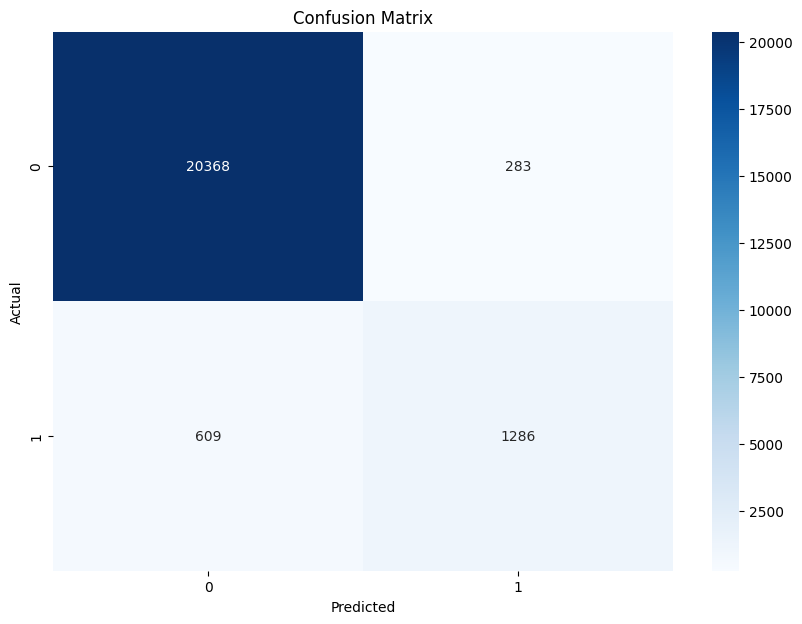

In [32]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Define the CatBoost classifier
catboost = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1, loss_function='Logloss', verbose=100, l2_leaf_reg= 1)

# Fit the model
catboost.fit(X_trainS2, y_trainS2)
y_predS = catboost.predict(X_valS)
print('Accuracy:', accuracy_score(y_valS, y_predS))
# Confusion Matrix
confusion(y_valS, y_predS)

# Define the CatBoost classifier
catboost = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1, loss_function='Logloss', verbose=100, l2_leaf_reg= 1)
catboost.fit(X_trainP2, y_trainP2)
y_predP = catboost.predict(X_valP)
print('Accuracy:', accuracy_score(y_valP, y_predP))
# Confusion Matrix
confusion(y_valP, y_predP)

In [47]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the LightGBM classifier
lgbm = LGBMClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.01],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [-1, 10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Score:', best_score)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183[LightGBM] [Info] Start training from score -1.507183

[LightGBM] [Info] Start training from score -1.507183
[LightGBM] [Info

/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
Best Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50, 'objective': 'binary'}
Best Score: 0.8733475479744136
Validation Accuracy: 0.8724946695095949


In [48]:
lgbm = LGBMClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.1],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [-1, 10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Score:', best_score)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183
[LightGBM] [Info] Number of positive: 13608, number of negative: 61432
[LightGBM] [Info] Start training from score -1.507183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGB

/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
Best Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50, 'objective': 'binary'}
Best Score: 0.8781538734896944
Validation Accuracy: 0.8785714285714286


In [49]:
lgbm = LGBMClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.3],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [-1, 10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Score:', best_score)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183
[LightGBM] [Info] Start training from score -1.507183
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of positive: 13608, number of negative: 61432
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGB

/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
Best Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 50, 'objective': 'binary'}
Best Score: 0.8781982942430705
Validation Accuracy: 0.8787135749822317


In [2]:
from sklearn.model_selection import train_test_split
split = 0.2
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=split, random_state=42)

NameError: name 'X_train' is not defined

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the XGBoost classifier
xgb = XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'objective': ['binary:logistic']
}


# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_

print('Best Parameters:', best_params)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.7}
Validation Accuracy: 0.9383357041251779


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=1, n_neurons=30, learning_rate=3e-3, epochs=10, batch_size=32):
        self.n_hidden = n_hidden
        self.n_neurons = n_neurons
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    
    def create_model(self, input_shape):
        model = Sequential()
        model.add(Dense(self.n_neurons, activation='relu', input_shape=input_shape))
        
        for _ in range(self.n_hidden):
            model.add(Dense(self.n_neurons, activation='relu'))
            
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
    
    def fit(self, X, y):
        # Create new model instance for each fit
        self.model = self.create_model(input_shape=[X.shape[1]])
        
        # Reshape y if needed
        y = np.array(y)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        # Fit the model
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        return self
    
    def predict(self, X):
        predictions = self.model.predict(X, verbose=0)
        return (predictions > 0.5).astype(int).ravel()
    
    def predict_proba(self, X):
        predictions = self.model.predict(X, verbose=0)
        return np.hstack([1 - predictions, predictions])

# Create model instance
model = KerasClassifierWrapper()

# Define the parameter grid
grid_params = {
    'n_hidden': [1, 2, 3],
    'n_neurons': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.3],
    'epochs': [10, 20],
    'batch_size': [10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)



# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_

print('Best Parameters:', best_params)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

2024-11-22 10:37:50.289083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:37:50.305820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:37:50.307371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:37:50.315537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732268270.315366   31137 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

Best Parameters: {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.01, 'n_hidden': 1, 'n_neurons': 10}
Validation Accuracy: 0.9365220483641536


In [48]:
# in X_test replace the nan values with the median of the column
X_test = X_test.fillna(X_test.median())

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# import gradient boosting and xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# Define the model creation function
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=input_shape))
    for _ in range(1):
        model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

input_shape = [X_train2.shape[1]]
model = create_model(input_shape)

# Train the model
history = model.fit(X_train2, y_train2, epochs=10, batch_size=10, validation_split=0.2)

# XGBoost Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}
xgb = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=200, objective='binary:logistic')

# Best Gradient Boosting parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 1.0}
gb = GradientBoostingClassifier(learning_rate=0.3, max_depth=3, min_samples_split=4, n_estimators=200, subsample=1.0)


# Stacking Classifier tensor flow, xgboost, gradient boosting

estimators = [('model', model), ('xgb', xgb), ('gb', gb)]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train2, y_train2)
y_pred = stack.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))

Epoch 1/10


/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8999/8999 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9263 - loss: 0.1830

KeyboardInterrupt: 

In [29]:
# Oversampling the train data
from imblearn.over_sampling import SMOTE

# Define the oversampling strategy
oversample = SMOTE()

# Fit and apply the transform
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train2, y_train2)

gb = GradientBoostingClassifier(learning_rate=0.3, max_depth=3, min_samples_split=4, n_estimators=200, subsample=1.0)


# Train the model
history = gb.fit(X_train_resampled, y_train_resampled)

# Predict the validation set
y_pred = gb.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))


Validation Accuracy: 0.936877667140825


In [22]:
import numpy as np
from sklearn.metrics import f1_score

# Assuming X_val and y_val are your validation data
# Get the predicted probabilities
y_pred_prob = model.predict(X_val)

# Define a range of thresholds to evaluate
thresholds = np.arange(0.0, 1.0, 0.01)

# Initialize variables to store the best threshold and best F1 score
best_threshold = 0.0
best_f1 = 0.0

# Evaluate F1 score at each threshold
for threshold in thresholds:
    y_pred = (y_pred_prob > threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1}')

# Use the best threshold to make final predictions
y_pred_final = (y_pred_prob > best_threshold).astype(int)
print(y_pred_final)

879/879 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step
Best Threshold: 0.42
Best F1 Score: 0.8310083325531318
[[1]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [44]:
# Best Gradient Boosting parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 1.0}
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split= 4, subsample= 1.0, random_state=42)

gb.fit(X_train2, y_train2)
y_pred = gb.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.8919331911869225


In [24]:
def prediction_finale(model, X_train, y_train, X_test, threshold=0.5):
    X_test = X_test.fillna(X_test.median())
    model.fit(X_train, y_train)
    sub = model.predict(X_test)
    sub = (sub > threshold).astype(int)
    submissions = pd.DataFrame(data=sub, columns=['Depression'])
    submissions['id'] = test['id']
    submissions = submissions[['id', 'Depression']]
    submissions.to_csv('submission.csv', index=False)

In [25]:
prediction_finale(model, X_train, y_train, X_test, 0.42)

 166/4394 ━━━━━━━━━━━━━━━━━━━━ 3s 943us/step - accuracy: 0.9298 - loss: 0.1657

2024-11-22 16:30:08.596896: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138348432 exceeds 10% of free system memory.


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9368 - loss: 0.1571
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step


In [ ]:
# todo : faire un tableau avec/sans PCA